In [1]:
import os
import sys
import yaml
from pathlib import Path
from pprint import pprint
import matplotlib
import matplotlib.pyplot as plt

# with open('gateway.yaml') as f:
#   gateway = yaml.safe_load(f)

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import decode
import decode.utils
import decode.neuralfitter.train.live_engine

import torch

#@markdown **Step 2** Download Sample Data
print(f"DECODE version {decode.utils.bookkeeping.decode_state()}")
print(f"Pytorch version {torch.__version__}")

# dir where to store example data, leave as '' to store in current folder
path = Path('')

# change here for other files
# package = gateway['examples']['colab_train_experimental_rc']

# get paths to files
# sample_folder = decode.utils.example_helper.load_example_package(
#     path=(path / package['name']).with_suffix('.zip'), url=package['url'], hash=package['hash'])

DECODE version 0.10.1
Pytorch version 2.3.1+cu118


In [2]:
import Net.CNNLSTM as LS
import Choose_Device as Device

param_file = 'network/experiment1/param_run.yaml'
param = decode.utils.param_io.load_params(param_file)
model_file = 'network/experiment1/model_2.pt'
model = LS.CNNBiLSTM(1, 10, seq_len=5, pad_convs=True, depth=2,initial_features=48, norm=None, norm_groups=None, sigma_eps_default=0.005).to(Device.device)
model = decode.utils.model_io.LoadSaveModel(model, 
                                            input_file=model_file, 
                                            output_file=None).load_init(device=Device.device)

Running on the GPU
Model instantiated.
Model SHA-1 hash: 7dc5a7d01f499532d41611c5ffcea46531a437d3
Loaded pretrained model: network\experiment1\model_2.pt


In [ ]:
def merge(frames, step, mode='max'):
    ret = []
    if mode=='max':
        for i in range(0,frames.size()[0],step):
            tmp = frames[i]
            for j in range(1, step):
                if i+j>=frames.size()[0]:
                    break
                tmp = torch.maximum(tmp,frames[i+j])
            ret.append(tmp)
    elif mode=='average':
        for i in range(0,frames.size()[0],step):
            tmp = frames[i]
            for j in range(1, step):
                if i+j>=frames.size()[0]:
                    break
                tmp += frames[i+j]
            tmp /= step
            ret.append(tmp)
    ret = torch.stack(ret)
    return ret
def work(param, frames, model):
    mirror_frame = True
    camera = decode.simulation.camera.Photon2Camera.parse(param)
    camera.device = 'cpu'
    device = 'cuda:0'

    post_raw_th = param.PostProcessingParam.raw_th
    frame_proc = decode.neuralfitter.utils.processing.TransformSequence([
        decode.neuralfitter.utils.processing.wrap_callable(camera.backward),
        decode.neuralfitter.frame_processing.AutoCenterCrop(8),
        decode.neuralfitter.scale_transform.AmplitudeRescale.parse(param)
    ])

    size_procced = decode.neuralfitter.frame_processing.get_frame_extent(frames.unsqueeze(1).size(), frame_proc.forward)  # frame size after processing
    frame_extent = ((0, size_procced[-2]), (0, size_procced[-1]))

    post_proc = decode.neuralfitter.utils.processing.TransformSequence([
        
        decode.neuralfitter.scale_transform.InverseParamListRescale.parse(param),
        
        decode.neuralfitter.coord_transform.Offset2Coordinate(xextent=frame_extent[0],
                                                            yextent=frame_extent[1],
                                                            img_shape=size_procced[-2:]),
        
        decode.neuralfitter.post_processing.SpatialIntegration(raw_th=post_raw_th,
                                                            xy_unit='px', 
                                                            px_size=param.Camera.px_size)
    ])
    infer_ts = decode.neuralfitter.Infer(model=model, ch_in=param.HyperParameter.channels_in,
                                    frame_proc=frame_proc, post_proc=post_proc,
                                    device=device, num_workers=0, pin_memory=False,
                                    batch_size='auto')
    
    em_pred = infer_ts.forward(frames)

    return em_pred

In [ ]:
frame_path = 'dataset/experimental_data_workflow/frames.tif'
frames = decode.utils.frames_io.load_tif(frame_path)
# frames = merge(frames,5,'max')
# frames = merge(frames,6,'average')
em_pred = work(param, frames, model)
print(em_pred)

d:\IDE\Anaconda3\envs\decode_env\lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
  0%|          | 2/625 [00:32<2:55:22, 16.89s/it]

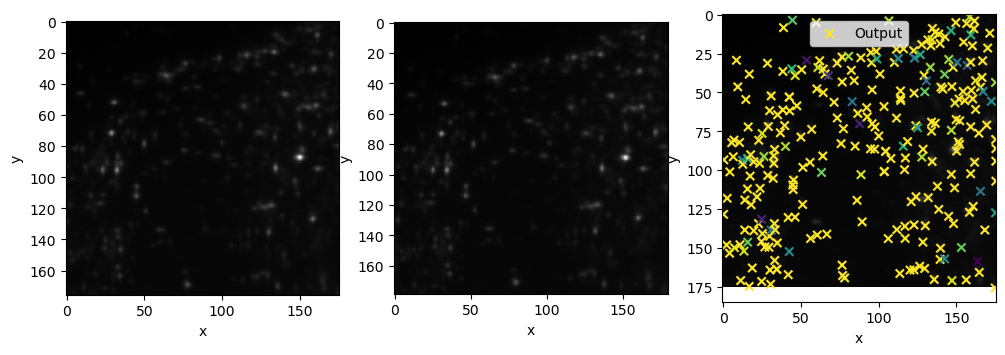

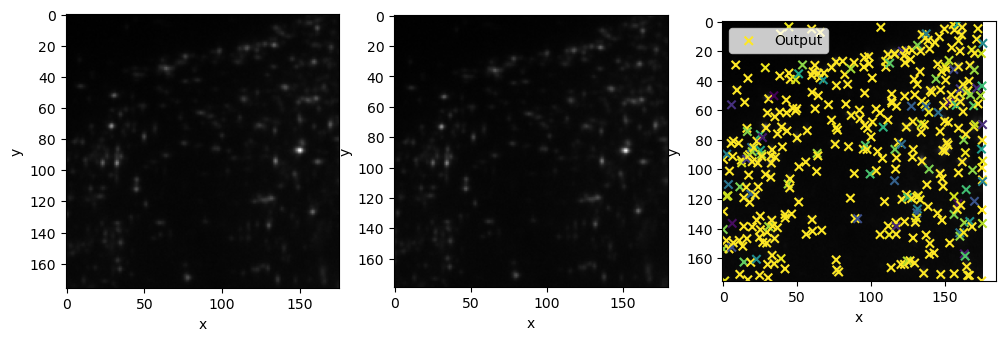

In [ ]:
#@markdown > Check random frame
import matplotlib.pyplot as plt

random_ix = 66
camera = decode.simulation.camera.Photon2Camera.parse(param)
frame_proc = decode.neuralfitter.utils.processing.TransformSequence([
    decode.neuralfitter.utils.processing.wrap_callable(camera.backward),
    decode.neuralfitter.frame_processing.AutoCenterCrop(8),
    decode.neuralfitter.scale_transform.AmplitudeRescale.parse(param)
])
em_subset = em_pred.get_subset_frame(random_ix, random_ix)
plt.figure(figsize=(12, 6))
plt.subplot(131)
decode.plot.PlotFrameCoord(frame=frame_proc.forward(frames[[random_ix]]).cpu()).plot()
plt.subplot(132)
decode.plot.PlotFrameCoord(frame=frames[[random_ix]]).plot()
plt.subplot(133)
decode.plot.PlotFrameCoord(frame=frame_proc.forward(frames[[random_ix]]).cpu(),
                        pos_out=em_subset.xyz_px, phot_out=em_subset.prob).plot()
plt.legend()
plt.show()
plt.close()

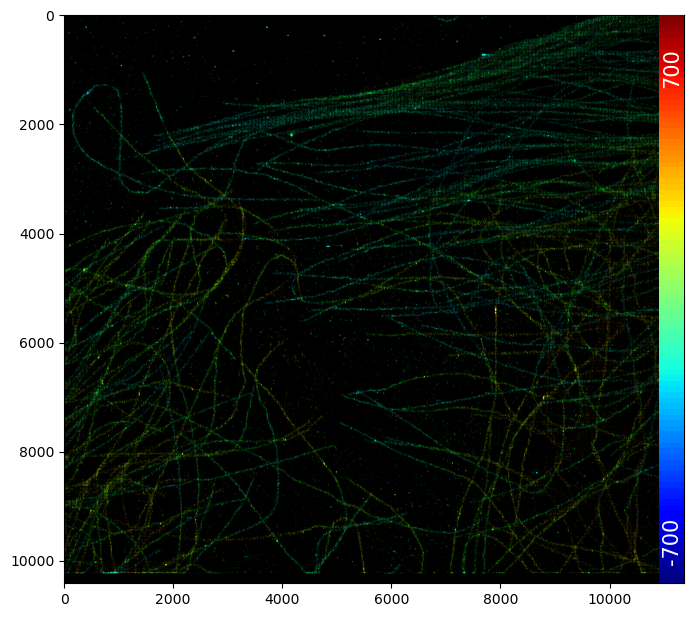

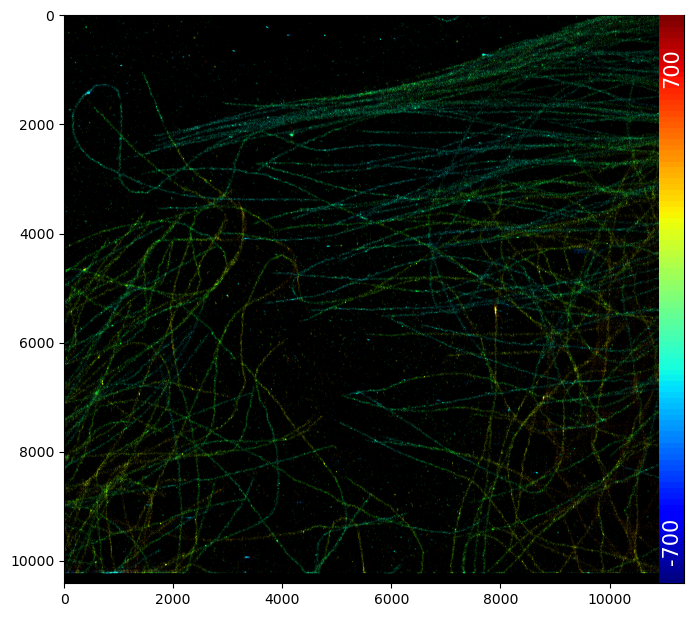

In [ ]:
#@markdown > Check Rendered Superres-Image (unfiltered)
# rendering tbd
sz_x = 180
sz_y = 179
xx = 127
yy = 117
plt.figure(figsize=(8, 8))
decode.renderer.renderer.Renderer2D(xextent=(xx, sz_x*xx), yextent=(yy, sz_y*yy), colextent=[-700,700], px_size=2., sigma_blur=5., rel_clip=0.05, contrast=50).render(em_pred, em_pred.xyz_nm[:,2])
plt.show()

100%|██████████| 6/6 [00:00<00:00, 38.22it/s]


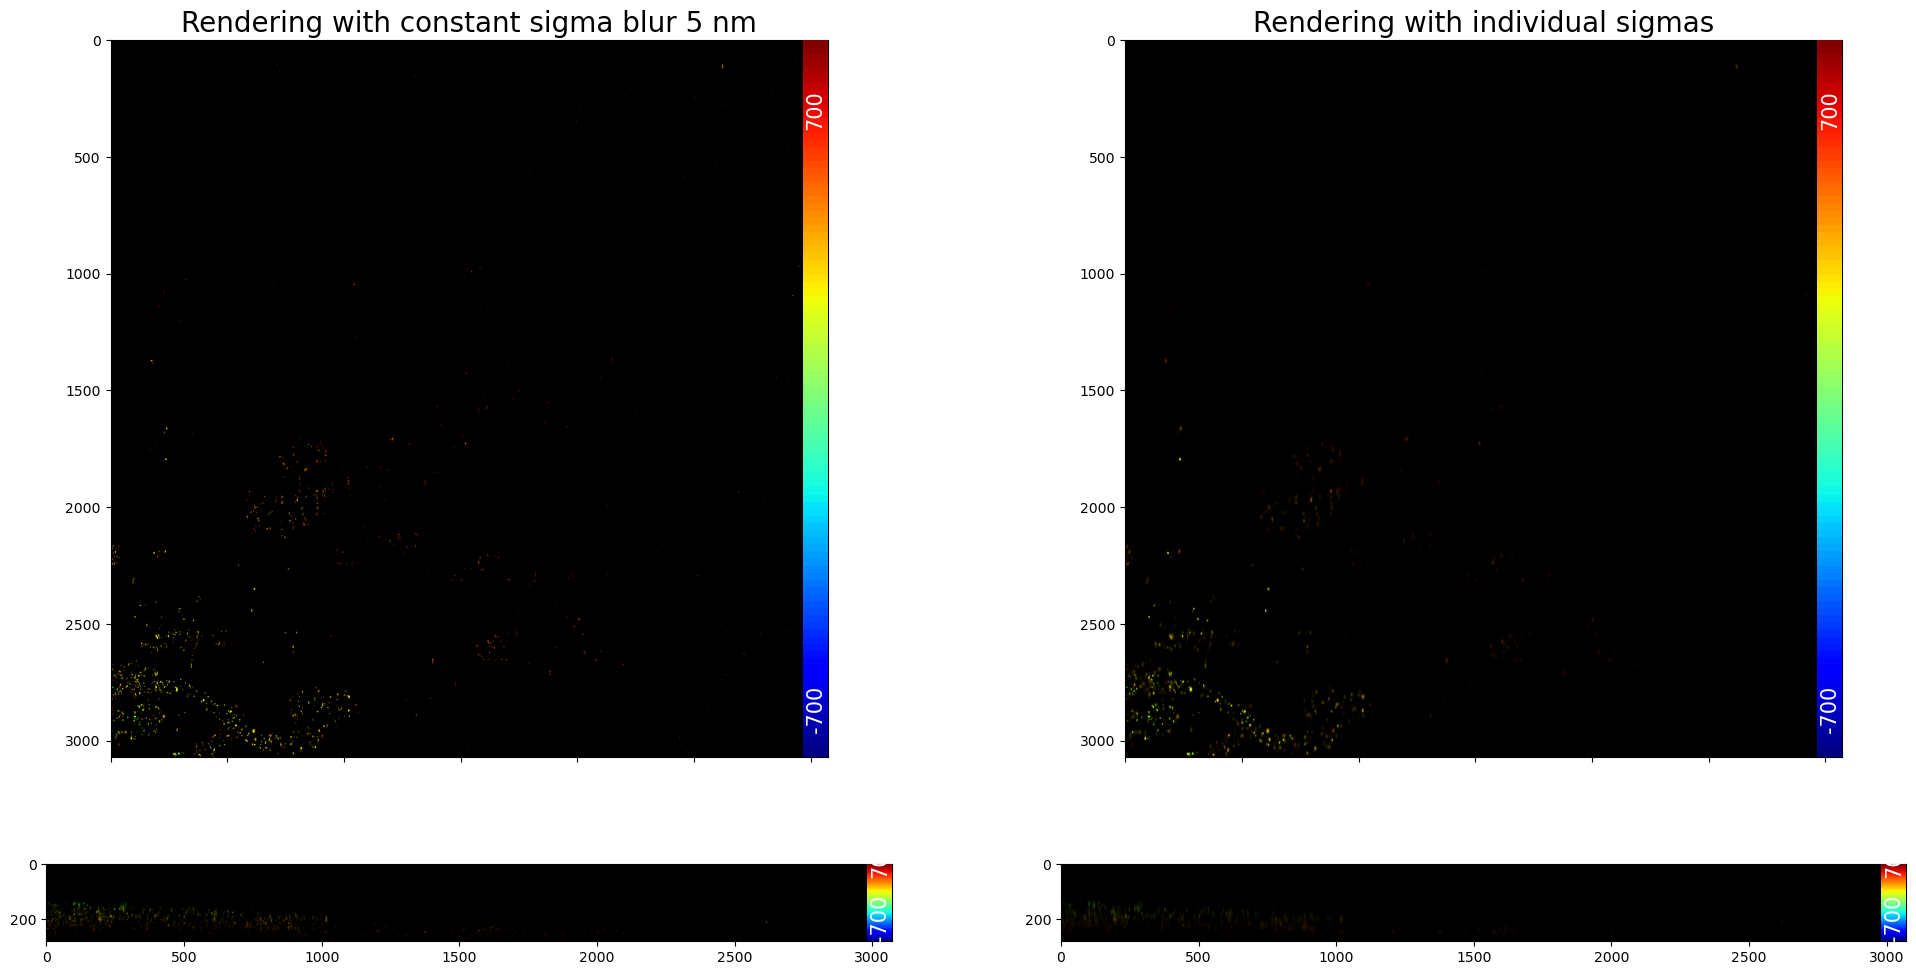

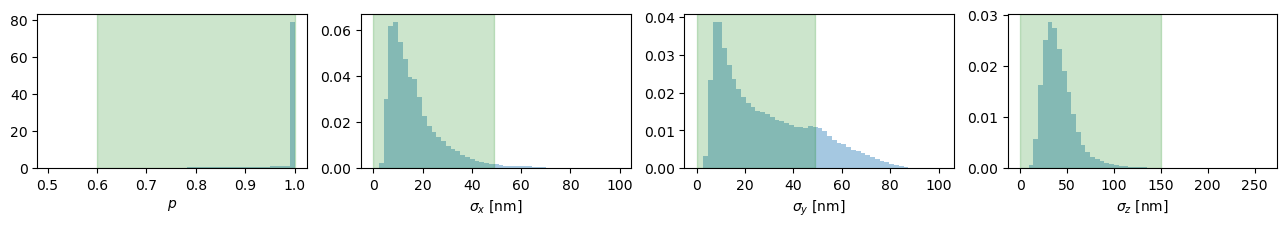

100%|██████████| 10/10 [00:00<00:00, 37.95it/s]


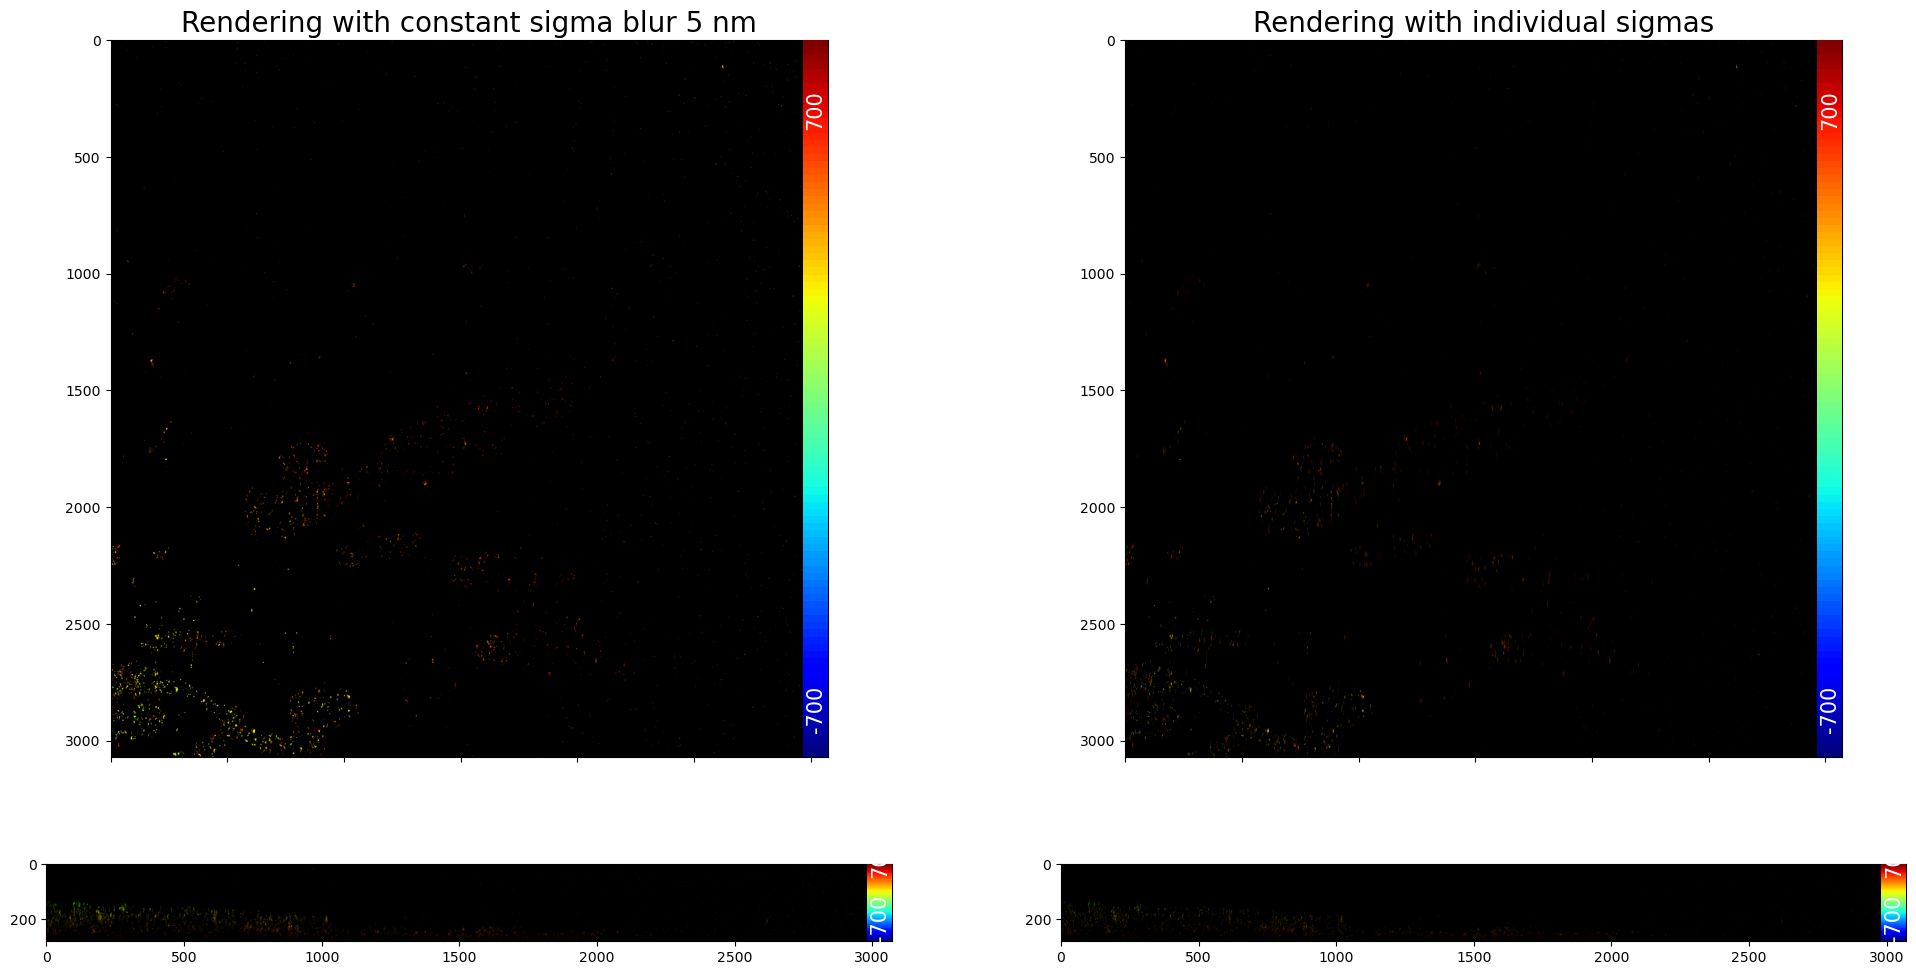

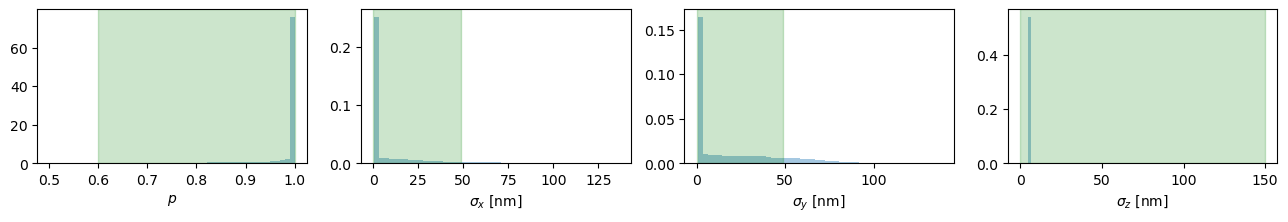

In [ ]:
p_low_threshold = 0.6 #@param {type:"slider", min:0, max:1, step:0.01}
sigma_x_high_threshold = 49 #@param {type:"slider", min:10, max:150, step:1}
sigma_y_high_threshold = 49 #@param {type:"slider", min:10, max:150, step:1}
sigma_z_high_threshold = 150 #@param {type:"slider", min:10, max:250, step:1}
em_sub = em_pred[em_pred.prob >= p_low_threshold]
em_sub = em_sub[(em_sub.xyz_sig_nm[:, 0] <= sigma_x_high_threshold) * (em_sub.xyz_sig_nm[:, 1] <= sigma_x_high_threshold) * (em_sub.xyz_sig_nm[:, 2] <= sigma_z_high_threshold)]
fig, axs = plt.subplots(2, 2, figsize=(24, 12), sharex='col',
                    gridspec_kw={'height_ratios': [1, 1200 / 7000]})
extents = {
    'xextent': [xx*sz_x/2, xx*sz_x],
    'yextent': [0, yy*sz_y/2],
    'zextent': [-700, 700],
    'colextent': [-700, 700]}
decode.renderer.Renderer2D(
    px_size=5., sigma_blur=5., rel_clip=None, abs_clip=3, **extents,
    plot_axis=(0, 1), contrast=10).render(em_sub, em_sub.xyz_px[:,2], ax=axs[0, 0])
decode.renderer.Renderer2D(
    px_size=5., sigma_blur=5., rel_clip=None, abs_clip=15, **extents,
    plot_axis=(0, 2), contrast=10).render(em_sub, em_sub.xyz_px[:,2], ax=axs[1, 0])
decode.renderer.RendererIndividual2D(
    px_size=5., filt_size=20, rel_clip=None, abs_clip=3, **extents,
    plot_axis=(0, 1), contrast=10).render(em_sub, em_sub.xyz_px[:,2], ax=axs[0, 1])
decode.renderer.RendererIndividual2D(
    px_size=5., filt_size=20, rel_clip=None, abs_clip=15, **extents,
    plot_axis=(0, 2), contrast=10).render(em_sub, em_sub.xyz_px[:,2], ax=axs[1, 1])

axs[0, 0].set_title('Rendering with constant sigma blur 5 nm', fontsize=20)
axs[0, 1].set_title('Rendering with individual sigmas', fontsize=20)
# plt.savefig(output_path+outputs[cnt])
plt.show()
plt.close()

plt.fig, ax = plt.subplots(1, 4, figsize=(16, 2))
sns.distplot(em_pred.prob, bins=50, norm_hist=True, kde=False, ax=ax[0])
ax[0].axvspan(p_low_threshold, 1., alpha=0.2, color='green')
ax[0].set_xlabel(r'$p$')

sns.distplot(em_pred.xyz_sig_nm[:, 0], bins=50, norm_hist=True, kde=False, ax=ax[1])
ax[1].axvspan(0., sigma_x_high_threshold, alpha=0.2, color='green')
ax[1].set_xlabel(r'$\sigma_x$ [nm]')

sns.distplot(em_pred.xyz_sig_nm[:, 1], bins=50, norm_hist=True, kde=False, ax=ax[2])
ax[2].axvspan(0., sigma_y_high_threshold, alpha=0.2, color='green')
ax[2].set_xlabel(r'$\sigma_y$ [nm]')

sns.distplot(em_pred.xyz_sig_nm[:, 2], bins=50, norm_hist=True, kde=False, ax=ax[3])
ax[3].axvspan(0., sigma_z_high_threshold, alpha=0.2, color='green')
ax[3].set_xlabel(r'$\sigma_z$ [nm]')

plt.show()
plt.close()